# Session 1 : Training your first aircraft classifier with pytorch

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Florient Chouteau | <a href="https://supaerodatascience.github.io/deep-learning/">https://supaerodatascience.github.io/deep-learning/</a>

### Intro

The objectives of this session is to apply what you learned during [the previous class on Deep Learning](https://supaerodatascience.github.io/deep-learning/) on a real dataset of satellite images.

Most of the vocabulary and concepts of Deep Learning and Convolutionnal Neural Network has been defined on the class linked above so you should refer to it.

The objective of the first session is to apply what was detailed above on another dataset using higher level tools such as [pytorch ignite].(https://github.com/pytorch/ignite)

In this session you will:
- Get more comfortable using [pytorch ignite](https://github.com/pytorch/ignite)
- Train a basic NN on a basic dataset
- Plot ROC curve & confusion matrix to diagnose your dataset

During session 2 you will be experimenting with harder datasets

If you haven't done so, go to the previous notebook to get a hands on pytorch ignite using a simple dataset called Fashion MNIST

### What is pytorch-ignite ?

<img src="https://raw.githubusercontent.com/pytorch/ignite/master/assets/logo/ignite_logo_mixed.svg" alt="ignite" style="width: 400px;"/>

Pytorch ignite is what we call a "high-level library" over pytorch, its objectives is to abstract away most of the boilerplate code for training deep neural network.

Usually, they make the development process easier by enabling you to focus on what's important instead of writing distributed and optimized training loops and plugging metrics / callbacks. Because we all forgot to call `.backward()` or `.zero_grad()` at least once.

Here an overview of the high-level libraries available for pytorch,

https://neptune.ai/blog/model-training-libraries-pytorch-ecosystem?utm_source=twitter&utm_medium=tweet&utm_campaign=blog-model-training-libraries-pytorch-ecosystem

Of these, we would like to highlight three of them:

- pytorch-ignite, officially sanctioned by the pytorch team (its repo lives at https://pytorch.org/ignite/), which is developped by [someone from Toulouse](https://twitter.com/vfdev_5) - yes there is a member of the pytorch team living in Toulouse, we are not THAT behind in ML/DL :wishful-thinking:

- pytorch-lightning (https://www.pytorchlightning.ai/) which has recently seen its 1.0 milestone and has bee developped to a company. It is more "research oriented" that pytorch-ignite, and with a lower abstraction level, but seems to enable more use case.

- skorch (https://github.com/skorch-dev/skorch). This class was previously written in skorch. Skorch mimics the scikit-learn API and allows bridging the two libraries together. It's a bit less powerful but you write much less code than the two libraries above, and if you are very familiar with scikit-learn, it could be very useful for fast prototyping


**Take a look at the [previous class](https://nbviewer.jupyter.org/github/SupaeroDataScience/deep-learning/blob/main/deep/PyTorch%20Ignite.ipynb), the [official examples](https://nbviewer.jupyter.org/github/pytorch/ignite/tree/master/examples/notebooks/) or the [documentation](https://pytorch.org/ignite/) if you need help using ignite**

In [74]:
%matplotlib inline

In [75]:
# Ensure ignite is installed, otherwise install it
!pip install pytorch-ignite

In [76]:
# Put your imports here
import numpy as np

## Dataset

Récupération et exploration du datset

In [77]:
# Configuration variables
TOY_DATASET_URL = "https://storage.googleapis.com/fchouteau-isae-deep-learning/toy_aircraft_dataset.npz"

andrej### Image (reminders)

A digital image is an image composed of picture elements, also known as pixels, each with finite, discrete quantities of numeric representation for its intensity or gray level that is an output from its two-dimensional functions fed as input by its spatial coordinates denoted with x, y on the x-axis and y-axis, respectively.

We represent images as matrixes,

Images are made of pixels, and pixels are made of combinations of primary colors (in our case Red, Green and Blue). In this context, images have chanels that are the grayscale image of the same size as a color image, made of just one of these primary colors. For instance, an image from a standard digital camera will have a red, green and blue channel. A grayscale image has just one channel.

In geographic information systems, channels are often referred to as raster bands.

![img](https://static.packt-cdn.com/products/9781789613964/graphics/e91171a3-f7ea-411e-a3e1-6d3892b8e1e5.png)


For the rest of this workshop we will use the following axis conventions for images

![conventions](https://storage.googleapis.com/fchouteau-isae-deep-learning/static/image_coordinates.png)

### Downloading the dataset

We will be using [numpy datasources](https://docs.scipy.org/doc/numpy/reference/generated/numpy.DataSource.html?highlight=datasources) to download the dataset. DataSources can be local files or remote files/URLs. The files may also be compressed or uncompressed. DataSource hides some of the low-level details of downloading the file, allowing you to simply pass in a valid file path (or URL) and obtain a file object.

The dataset is in npz format which is a packaging format where we store several numpy arrays in key-value format

Note:
If you get an error with the code below run:
```python
!gsutil -m cp -r gs://isae-deep-learning/toy_aircraft_dataset.npz /tmp/storage.googleapis.com/isae-deep-learning/toy_aircraft_dataset.npz
```
in a cell above the cell below

In [78]:
ds = np.DataSource(destpath="/tmp/")
f = ds.open(TOY_DATASET_URL, "rb")

toy_dataset = np.load(f)
trainval_images = toy_dataset["train_images"]
trainval_labels = toy_dataset["train_labels"]
test_images = toy_dataset["test_images"]
test_labels = toy_dataset["test_labels"]

### A bit of data exploration

**Q1. Labels counting**

a. What is the dataset size ?

b. How many images representing aircrafts ?

c. How many images representing backgrounds ?

d. What are the dimensions (height and width) of the images ? What are the number of channels ?

In [79]:
trainval_images.shape, trainval_labels.shape, test_images.shape, test_labels.shape

((2688, 64, 64, 3), (2688,), (896, 64, 64, 3), (896,))

In [80]:
np.unique(trainval_labels, return_counts=True), np.unique(test_labels, return_counts=True)

((array([0, 1]), array([1344, 1344])), (array([0, 1]), array([448, 448])))

a. 2688 + 896 images 64x64

b. 1344 + 448 aircrafts

c. 1344 + 448 backgrounds

d. 64 x 64, 3 colors

**Q2. Can you plot at least 8 examples of each label ? In a 4x4 grid ?**

In [81]:
trainval_images.shape*3

(2688, 64, 64, 3, 2688, 64, 64, 3, 2688, 64, 64, 3)

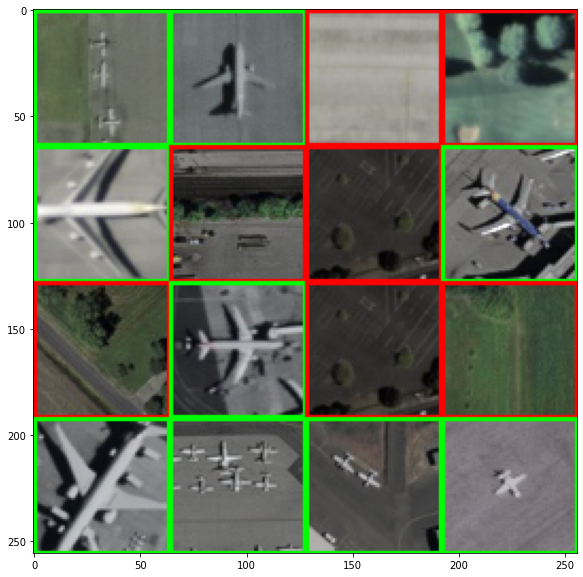

In [82]:
import cv2
import matplotlib.pyplot as plt
grid_size = 4
grid = np.zeros((grid_size*trainval_images.shape[1], grid_size*trainval_images.shape[2], trainval_images.shape[3])).astype(np.uint8)
for i in range(grid_size):
    for j in range(grid_size):
        _ = np.random.choice(len(trainval_images))
        image, label = np.copy(trainval_images[_]), trainval_labels[_]
        tile = cv2.rectangle(image, (0, 0), (64, 64), (0, 255, 0) if label==1 else (255, 0, 0), thickness=2)
        grid[64*i:64*(i+1), 64*j:64*(j+1)] = tile

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(grid)
plt.show()

Here are some examples that help you answer this question. Try them and make your own. A well-understandood dataset is the key to an efficient model.

In [83]:
import cv2
import matplotlib.pyplot as plt

In [84]:
LABEL_NAMES = ["Not an aircraft", "Aircraft"]

print("Labels counts :")
for l, c, label in zip(*np.unique(trainval_labels, return_counts=True), LABEL_NAMES):
    print(f" Label: {label} , value: {l}, count: {c}")

for l, label in enumerate(LABEL_NAMES):
    print(f"Examples shape for label {l} : {trainval_images[trainval_labels == l, ::].shape}")

Labels counts :
 Label: Not an aircraft , value: 0, count: 1344
 Label: Aircraft , value: 1, count: 1344
Examples shape for label 0 : (1344, 64, 64, 3)
Examples shape for label 1 : (1344, 64, 64, 3)


In [85]:
LABEL_NAMES = ["Not an aircraft", "Aircraft"]

print("Labels counts :")
for l, c, label in zip(*np.unique(test_labels, return_counts=True), LABEL_NAMES):
    print(f" Label: {label} , value: {l}, count: {c}")

for l, label in enumerate(LABEL_NAMES):
    print(f"Examples shape for label {l} : {test_images[test_labels == l, ::].shape}")

Labels counts :
 Label: Not an aircraft , value: 0, count: 448
 Label: Aircraft , value: 1, count: 448
Examples shape for label 0 : (448, 64, 64, 3)
Examples shape for label 1 : (448, 64, 64, 3)


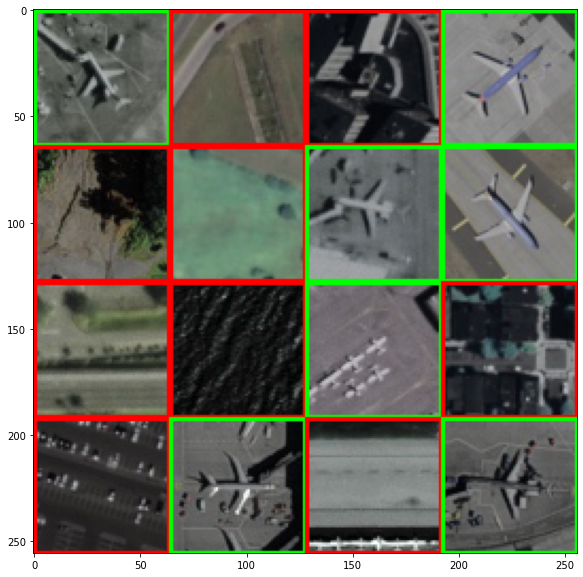

In [86]:
grid_size = 4
grid = np.zeros((grid_size * 64, grid_size * 64, 3)).astype(np.uint8)
for i in range(grid_size):
    for j in range(grid_size):
        tile = np.copy(trainval_images[i * grid_size + j])
        label = np.copy(trainval_labels[i * grid_size + j])
        color = (0, 255, 0) if label == 1 else (255, 0, 0)
        tile = cv2.rectangle(tile, (0, 0), (64, 64), color, thickness=2)
        grid[i * 64 : (i + 1) * 64, j * 64 : (j + 1) * 64, :] = tile

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(grid)
plt.show()

### A bit about train-test

You just downloaded a training and a test set.

- We use the training set for forward/backward
- We use the validation set to tune hyperparameters (optimizers, early stopping)
- We use the test set for final metrics on our tuned model

![](https://i.stack.imgur.com/osBuF.png)

For more information as to why we use train/validation and test refer to these articles:
https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7

https://www.freecodecamp.org/news/what-to-do-when-your-training-and-testing-data-come-from-different-distributions-d89674c6ecd8/

https://kevinzakka.github.io/2016/09/26/applying-deep-learning/

We will now create our validation dataset,

Since we know the dataset is balanced, we can evenly sample from the dataset without taking too many risks

We will do a 80/20 sampling

In [87]:
idxs = np.random.permutation(np.arange(trainval_images.shape[0]))

train_idxs, val_idxs = idxs[: int(0.8 * len(idxs))], idxs[int(0.8 * len(idxs)) :]

train_images = trainval_images[train_idxs]
train_labels = trainval_labels[train_idxs]
val_images = trainval_images[val_idxs]
val_labels = trainval_labels[val_idxs]

In [88]:
train_images.shape

(2150, 64, 64, 3)

## Training using pytorch-ignite

In order to simplify the code, we will use the [pytorch-ignite](https://github.com/pytorch/ignite) library. It provides a convenient wrapper and avoid the need of re writing the training loop eah time:

```python
for epoch in range(10):
    for batch in batches:
        # torch forward
        # torch backward
```

If you still prefer writing your own loop, feel free to overwrite the next cells.

If you need any help with functionalities of ignite, you [can find here](https://nbviewer.jupyter.org/github/pytorch/ignite/tree/master/examples/notebooks/) the reference notebooks of the library

In [89]:
from typing import Callable

import torch
import torch.nn.functional as F
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

### Defining Dataset & Transforms

In [90]:
## Define dataset

## We write our own Dataset class
class NpArrayDataset(Dataset):
    def __init__(
        self,
        images: np.ndarray,
        labels: np.ndarray,
        image_transforms: Callable = None,
        label_transforms: Callable = None,
    ):
        self.images = images
        self.labels = labels
        self.image_transforms = image_transforms
        self.label_transforms = label_transforms

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index: int):
        x = self.images[index]
        y = self.labels[index]

        if self.image_transforms is not None:
            x = self.image_transforms(x)
        else:
            x = torch.tensor(x)

        if self.label_transforms is not None:
            y = self.label_transforms(y)
        else:
            y = torch.tensor(y)

        return x, y

In [91]:
# transform to convert np array in range [0,255] to torch.Tensor [0.,1.]
image_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

target_transforms = None

# load the training data
train_set = NpArrayDataset(
    images=train_images, labels=train_labels, image_transforms=image_transforms, label_transforms=target_transforms
)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

# load the validation data
validation_set = NpArrayDataset(
    images=val_images, labels=val_labels, image_transforms=image_transforms, label_transforms=target_transforms
)
val_loader = DataLoader(validation_set, batch_size=64, shuffle=True)

### Check that your dataset outputs correct data

Always to this as a sanity check to catch bugs in your data processing pipeline

Write the inverse transformation by hand to ensure it's ok

![andrej](https://storage.googleapis.com/fchouteau-isae-deep-learning/static/andrej_tweet_1.png)

Inverse transform is OK ? True
Label 1


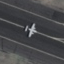

In [92]:
x, y = train_set[3]
x = x.numpy()
x = (x * 255.0).astype(np.uint8).transpose((1, 2, 0))

print("Inverse transform is OK ? {}".format(np.all(train_set.images[3] == x)))
print("Label {}".format(y))
Image.fromarray(x.astype(np.uint8))

Model

In [93]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [94]:
# Define the torch model to use
# Here a sequential layer is used instead of the classical nn.Module
# If you need to write your own module, plenty of resources are available one the web or in deep learning course


def model_fn():
    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, 3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(64, 64, 3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(6 * 6 * 64, 256),
        nn.ReLU(),
        nn.Dropout(p=0.25),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Dropout(p=0.25),
        nn.Linear(64, 2),
        nn.LogSoftmax(dim=-1),
    )

    return model


model = model_fn()

# moving model to gpu if available
model.to(DEVICE)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=2304, out_features=256, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.25, inplace=False)
  (16): Linear(in_features=256, out_features=64, bias=True)
  (17): ReLU()

### Defining High level Training functions

In [95]:
import ignite.engine
import ignite.handlers
import ignite.metrics
import ignite.utils
from ignite.engine import Events

In [96]:
# declare optimizers and loss
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

Below we create 3 engines, a trainer, an evaluator for the training set and an evaluator for the validation set, by using the `create_supervised_trainer` and `create_supervised_evaluator` and passing the required arguments.

We import the metrics from `ignite.metrics` which we want to calculate for the model. Like `Accuracy`, `ConfusionMatrix`, and `Loss` and we pass them to `evaluator` engines which will calculate these metrics for each iteration.

* `training_history`: it stores the training loss and accuracy
* `validation_history`:it stores the validation loss and accuracy
* `last_epoch`: it stores the last epoch untill the model is trained

We will also attach a metric of `RunningAverage` to track a running average of the scalar loss output for each batch.

In [97]:
# defining the number of epochs
epochs = 12

# creating trainer
trainer = ignite.engine.create_supervised_trainer(model=model, optimizer=optimizer, loss_fn=criterion, device=DEVICE)

# create metrics
metrics = {
    "accuracy": ignite.metrics.Accuracy(),
    "nll": ignite.metrics.Loss(criterion),
    "cm": ignite.metrics.ConfusionMatrix(num_classes=2),
}

ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

# Evaluators
train_evaluator = ignite.engine.create_supervised_evaluator(model, metrics=metrics, device=DEVICE)
val_evaluator = ignite.engine.create_supervised_evaluator(model, metrics=metrics, device=DEVICE)

# Logging
train_evaluator.logger = ignite.utils.setup_logger("train")
val_evaluator.logger = ignite.utils.setup_logger("val")

# init variables for logging
training_history = {"accuracy": [], "loss": []}
validation_history = {"accuracy": [], "loss": []}
last_epoch = []

Lastly, we want to checkpoint this model. It's important to do so, as training processes can be time consuming and if for some reason something goes wrong during training, a model checkpoint can be helpful to restart training from the point of failure.

Below we will use Ignite's `ModelCheckpoint` handler to checkpoint models at the end of each epoch.

In [98]:
model_name = "basic_cnn"
dataset_name = "toy_aircrafts"

checkpointer = ignite.handlers.ModelCheckpoint(
    "./saved_models",
    filename_prefix=dataset_name,
    n_saved=2,
    create_dir=True,
    save_as_state_dict=True,
    require_empty=False,
)

trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {model_name: model})

Below you will see ways to define your own custom functions and attaching them to various `Events` of the training process.

The functions below both achieve similar tasks, they print the results of the evaluator run on a dataset. One function does that on the training evaluator and dataset, while the other on the validation. Another difference is how these functions are attached in the trainer engine.

The first method involves using a decorator, the syntax is simple - `@` `trainer.on(Events.EPOCH_COMPLETED)`, means that the decorated function will be attached to the trainer and called at the end of each epoch.

The second method involves using the add_event_handler method of trainer - `trainer.add_event_handler(Events.EPOCH_COMPLETED, custom_function)`. This achieves the same result as the above.

In [99]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics["accuracy"] * 100
    loss = metrics["nll"]
    last_epoch.append(0)
    training_history["accuracy"].append(accuracy)
    training_history["loss"].append(loss)
    print(
        "Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
            trainer.state.epoch, accuracy, loss
        )
    )


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    accuracy = metrics["accuracy"] * 100
    loss = metrics["nll"]
    validation_history["accuracy"].append(accuracy)
    validation_history["loss"].append(loss)
    print(
        "Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
            trainer.state.epoch, accuracy, loss
        )
    )

### Training

We will actually train the model (run the training engine), and plot training & validation metrics during training

In [100]:
trainer.run(train_loader, max_epochs=epochs)

2020-11-30 14:26:12,877 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:13,280 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:13,281 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:26:13,290 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:13,396 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:13,398 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 1  Avg accuracy: 50.05 Avg loss: 0.68
Validation Results - Epoch: 1  Avg accuracy: 49.81 Avg loss: 0.68


2020-11-30 14:26:14,264 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:14,672 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:14,673 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:26:14,677 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:14,790 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:14,791 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 2  Avg accuracy: 66.09 Avg loss: 0.61
Validation Results - Epoch: 2  Avg accuracy: 66.91 Avg loss: 0.61


2020-11-30 14:26:15,660 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:16,059 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:16,060 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:26:16,067 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:16,169 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:16,170 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 3  Avg accuracy: 75.26 Avg loss: 0.57
Validation Results - Epoch: 3  Avg accuracy: 76.58 Avg loss: 0.56


2020-11-30 14:26:17,037 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:17,441 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:17,442 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:26:17,443 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:17,555 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:17,557 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 4  Avg accuracy: 81.21 Avg loss: 0.53
Validation Results - Epoch: 4  Avg accuracy: 81.04 Avg loss: 0.53


2020-11-30 14:26:18,417 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:18,827 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:18,828 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:26:18,829 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:18,937 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:18,938 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 5  Avg accuracy: 85.58 Avg loss: 0.49
Validation Results - Epoch: 5  Avg accuracy: 86.25 Avg loss: 0.48


2020-11-30 14:26:19,798 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:20,202 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:20,203 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:26:20,206 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:20,323 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:20,325 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 6  Avg accuracy: 87.72 Avg loss: 0.45
Validation Results - Epoch: 6  Avg accuracy: 88.85 Avg loss: 0.44


2020-11-30 14:26:21,201 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:21,601 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:21,602 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:26:21,606 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:21,709 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:21,710 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 7  Avg accuracy: 88.23 Avg loss: 0.42
Validation Results - Epoch: 7  Avg accuracy: 89.22 Avg loss: 0.41


2020-11-30 14:26:22,574 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:22,974 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:22,975 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:26:22,981 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:23,099 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:23,100 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 8  Avg accuracy: 89.91 Avg loss: 0.39
Validation Results - Epoch: 8  Avg accuracy: 90.89 Avg loss: 0.37


2020-11-30 14:26:23,972 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:24,376 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:24,380 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:26:24,382 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:24,489 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:24,490 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 9  Avg accuracy: 90.88 Avg loss: 0.35
Validation Results - Epoch: 9  Avg accuracy: 92.01 Avg loss: 0.34


2020-11-30 14:26:25,344 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:25,739 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:25,741 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:26:25,745 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:25,849 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:25,850 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 10  Avg accuracy: 91.67 Avg loss: 0.33
Validation Results - Epoch: 10  Avg accuracy: 92.94 Avg loss: 0.31


2020-11-30 14:26:26,705 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:27,105 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:27,106 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:26:27,107 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:27,215 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:27,217 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 11  Avg accuracy: 92.05 Avg loss: 0.30
Validation Results - Epoch: 11  Avg accuracy: 92.57 Avg loss: 0.29


2020-11-30 14:26:28,076 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:28,481 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:28,482 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:26:28,483 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:28,595 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:28,596 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 12  Avg accuracy: 92.93 Avg loss: 0.28
Validation Results - Epoch: 12  Avg accuracy: 92.75 Avg loss: 0.26


State:
	iteration: 408
	epoch: 12
	epoch_length: 34
	max_epochs: 12
	output: 0.2808859348297119
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: torch.utils.data.dataloader.DataLoader
	seed: <class 'NoneType'>
	times: <class 'dict'>

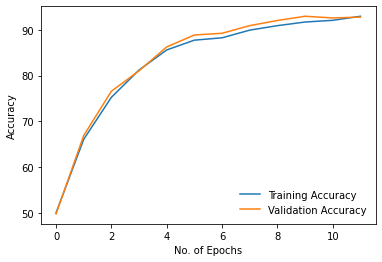

In [101]:
plt.plot(training_history["accuracy"], label="Training Accuracy")
plt.plot(validation_history["accuracy"], label="Validation Accuracy")
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.legend(frameon=False)
plt.show()

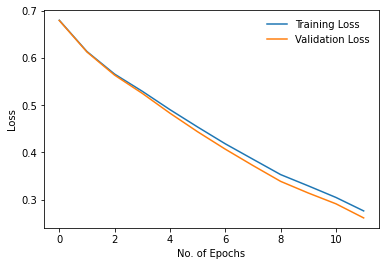

In [102]:
plt.plot(training_history["loss"], label="Training Loss")
plt.plot(validation_history["loss"], label="Validation Loss")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()

Now, clear the model from memory

In [41]:
del model

## Testing and metrics

Now that we have a trained network, it is important to measure how well it performs. We do not do that during training because theoretically we try to test on a context closer to how the final model will be used, meaning this can be another pipeline and is usually outside the training engine.

You can refer to your ML course or on resources on the web to see how we can measure it.

### Loading saved model

In [103]:
# loading the saved model
def fetch_last_checkpoint_model_filename(model_save_path: str, model_prefix: str):
    import os
    from pathlib import Path

    checkpoint_files = Path(model_save_path)
    checkpoint_files = checkpoint_files.glob("{}*.pt".format(model_prefix))
    checkpoint_files = [str(ckpt.resolve().name) for ckpt in checkpoint_files]
    checkpoint_iter = [int(x.split("_")[-1].split(".")[0]) for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()

    checkpoint_file = os.path.join(model_save_path, checkpoint_files[last_idx])
    print(checkpoint_file)
    return checkpoint_file


checkpoint_path = fetch_last_checkpoint_model_filename("./saved_models", "{}_{}".format(dataset_name, model_name))

print(checkpoint_path)
# Instantiate a new empty model
model = model_fn()

# Load state
model.load_state_dict(torch.load(checkpoint_path))

print("Model Loaded")

./saved_models/toy_aircrafts_basic_cnn_2550.pt
./saved_models/toy_aircrafts_basic_cnn_2550.pt
Model Loaded


### Inferencing on the test dataset

Now we will run predictions on the test dataset using the newly loaded model

In [104]:
test_ds = NpArrayDataset(
    images=test_images, labels=test_labels, image_transforms=image_transforms, label_transforms=target_transforms
)

In [105]:
import tqdm

In [106]:
y_true = []
y_pred = []

# Send model to correct device
model.to(DEVICE)

# Put model in evaluatio mode (very important)
model.eval()

# Disable all gradients things
with torch.no_grad():
    for x, y_t in tqdm.tqdm(test_ds, "predicting"):
        x = x.reshape((-1,) + x.shape)
        x = x.to(DEVICE)
        y = torch.exp(model.forward(x))
        y = y.to("cpu").numpy()

        y_t = int(y_t.to("cpu").numpy())

        y_pred.append(y)
        y_true.append(y_t)
y_pred = np.concatenate(y_pred, axis=0)
y_true = np.asarray(y_true)

predicting: 100%|██████████| 896/896 [00:01<00:00, 668.50it/s]


In [107]:
print(y_pred.shape)

print(y_pred[0])

(896, 2)
[0.572863   0.42713708]


In [108]:
y_pred_classes = np.argmax(y_pred, axis=1)

### Confusion matrix
Here, we are first computing the [confusion matrix]():

In [109]:
from sklearn.metrics import confusion_matrix

print("Confusion matrix")
confusion_matrix(y_true, y_pred_classes)

Confusion matrix


array([[441,   7],
       [ 64, 384]])

### ROC curve

The next metric we are computing is the [ROC curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html).

It used to choose a threshold on the output probability in case you are intesrested in controling the false positive rate.

In [110]:
from sklearn.metrics import auc, roc_curve

# Compute ROC curve and ROC area for each class

fpr, tpr, _ = roc_curve(
    y_true,
    y_pred[:, 1],
)
roc_auc = auc(fpr, tpr)

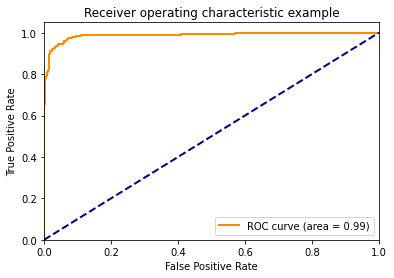

In [111]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

### Misclassified examples

It is always interesting to check mis classified examples.

It usually provides tips on how to improve your model.

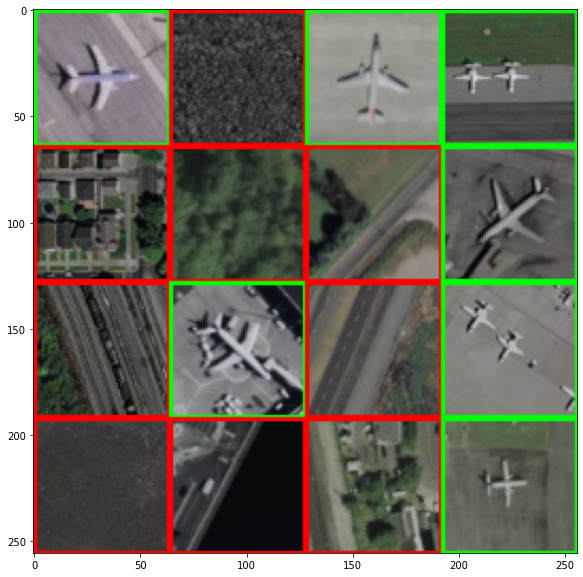

In [112]:
misclassified_idxs = np.where(y_pred_classes != y_true)

misclassified_images = train_images[misclassified_idxs]
misclassified_labels = train_labels[misclassified_idxs]

grid_size = 4
grid = np.zeros((grid_size * 64, grid_size * 64, 3)).astype(np.uint8)
for i in range(grid_size):
    for j in range(grid_size):
        img = np.copy(misclassified_images[i * grid_size + j])
        lbl = np.copy(misclassified_labels[i * grid_size + j])
        color = (0, 255, 0) if lbl == 1 else (255, 0, 0)
        tile = cv2.rectangle(img, (0, 0), (64, 64), color, thickness=2)
        grid[i * 64 : (i + 1) * 64, j * 64 : (j + 1) * 64, :] = img

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(grid)
plt.show()

## Using more advanced features with pytorch-ignite

We will add more advanced features using handlers and data augmentation,

Here, either write a new loop or edit the train loop above

### Adding more handlers: Early stopping

Now we will setup a `EarlyStopping` handler for this training process. EarlyStopping requires a score_function that allows the user to define whatever criteria to stop trainig. In this case, if the loss of the validation set does not decrease in 10 epochs, the training process will stop early. Since the `EarlyStopping` handler relies on the validation loss, it's attached to the `val_evaluator`.


```python
def score_function(engine):
    val_loss = engine.state.metrics["nll"]
    return -val_loss

handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

val_evaluator.add_event_handler(Events.COMPLETED, handler)
```

Add this to your training engine (you can then start the training again and train for longer)

In [113]:
def score_function(engine):
    val_loss = engine.state.metrics['nll']
    return -val_loss

handler = ignite.handlers.EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

val_evaluator.add_event_handler(Events.COMPLETED, handler)

In [114]:
trainer.run(train_loader, max_epochs=999)

2020-11-30 14:26:53,990 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:54,386 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:54,387 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:26:54,393 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:54,505 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:54,506 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 13  Avg accuracy: 93.58 Avg loss: 0.25
Validation Results - Epoch: 13  Avg accuracy: 94.24 Avg loss: 0.24


2020-11-30 14:26:55,373 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:55,774 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:55,776 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:26:55,779 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:55,883 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:55,885 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 14  Avg accuracy: 94.23 Avg loss: 0.24
Validation Results - Epoch: 14  Avg accuracy: 94.61 Avg loss: 0.23


2020-11-30 14:26:56,755 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:57,160 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:57,161 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:26:57,162 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:57,269 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:57,270 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 15  Avg accuracy: 94.88 Avg loss: 0.22
Validation Results - Epoch: 15  Avg accuracy: 94.98 Avg loss: 0.21


2020-11-30 14:26:58,137 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:58,533 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:58,535 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:26:58,538 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:58,648 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:58,649 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 16  Avg accuracy: 95.30 Avg loss: 0.21
Validation Results - Epoch: 16  Avg accuracy: 95.17 Avg loss: 0.20


2020-11-30 14:26:59,520 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:26:59,928 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:26:59,929 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:26:59,930 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:00,049 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:00,050 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 17  Avg accuracy: 95.40 Avg loss: 0.19
Validation Results - Epoch: 17  Avg accuracy: 94.98 Avg loss: 0.19


2020-11-30 14:27:00,919 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:01,325 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:01,326 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:01,327 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:01,438 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:01,439 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 18  Avg accuracy: 95.67 Avg loss: 0.18
Validation Results - Epoch: 18  Avg accuracy: 95.35 Avg loss: 0.18


2020-11-30 14:27:02,298 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:02,702 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:02,703 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:02,705 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:02,814 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:02,815 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 19  Avg accuracy: 95.72 Avg loss: 0.17
Validation Results - Epoch: 19  Avg accuracy: 95.35 Avg loss: 0.16


2020-11-30 14:27:03,690 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:04,095 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:04,096 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:04,097 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:04,207 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:04,208 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 20  Avg accuracy: 95.81 Avg loss: 0.16
Validation Results - Epoch: 20  Avg accuracy: 95.35 Avg loss: 0.16


2020-11-30 14:27:05,072 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:05,465 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:05,466 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:05,469 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:05,573 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:05,575 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 21  Avg accuracy: 96.19 Avg loss: 0.15
Validation Results - Epoch: 21  Avg accuracy: 95.54 Avg loss: 0.15


2020-11-30 14:27:06,445 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:06,849 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:06,850 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:06,851 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:06,962 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:06,964 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 22  Avg accuracy: 96.37 Avg loss: 0.15
Validation Results - Epoch: 22  Avg accuracy: 95.35 Avg loss: 0.14


2020-11-30 14:27:07,827 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:08,232 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:08,233 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:08,235 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:08,346 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:08,347 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 23  Avg accuracy: 96.37 Avg loss: 0.14
Validation Results - Epoch: 23  Avg accuracy: 95.72 Avg loss: 0.14


2020-11-30 14:27:09,209 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:09,607 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:09,608 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:09,609 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:09,724 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:09,725 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 24  Avg accuracy: 96.51 Avg loss: 0.13
Validation Results - Epoch: 24  Avg accuracy: 95.72 Avg loss: 0.13


2020-11-30 14:27:10,592 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:11,006 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:11,007 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:11,008 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:11,116 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:11,117 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 25  Avg accuracy: 96.47 Avg loss: 0.13
Validation Results - Epoch: 25  Avg accuracy: 95.72 Avg loss: 0.13


2020-11-30 14:27:11,977 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:12,386 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:12,387 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:12,389 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:12,498 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:12,500 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 26  Avg accuracy: 96.84 Avg loss: 0.12
Validation Results - Epoch: 26  Avg accuracy: 96.28 Avg loss: 0.13


2020-11-30 14:27:13,369 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:13,765 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:13,766 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:13,767 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:13,876 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:13,877 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 27  Avg accuracy: 96.74 Avg loss: 0.12
Validation Results - Epoch: 27  Avg accuracy: 95.91 Avg loss: 0.12


2020-11-30 14:27:14,751 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:15,152 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:15,154 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:15,159 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:15,269 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:15,271 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 28  Avg accuracy: 96.98 Avg loss: 0.12
Validation Results - Epoch: 28  Avg accuracy: 96.28 Avg loss: 0.12


2020-11-30 14:27:16,138 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:16,546 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:16,547 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:16,551 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:16,660 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:16,662 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 29  Avg accuracy: 96.79 Avg loss: 0.11
Validation Results - Epoch: 29  Avg accuracy: 96.28 Avg loss: 0.12


2020-11-30 14:27:17,524 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:17,921 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:17,922 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:17,927 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:18,031 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:18,032 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 30  Avg accuracy: 97.07 Avg loss: 0.11
Validation Results - Epoch: 30  Avg accuracy: 96.28 Avg loss: 0.12


2020-11-30 14:27:18,897 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:19,307 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:19,308 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:19,311 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:19,416 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:19,416 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 31  Avg accuracy: 97.02 Avg loss: 0.11
Validation Results - Epoch: 31  Avg accuracy: 96.28 Avg loss: 0.11


2020-11-30 14:27:20,273 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:20,667 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:20,668 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:20,673 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:20,777 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:20,778 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 32  Avg accuracy: 96.88 Avg loss: 0.11
Validation Results - Epoch: 32  Avg accuracy: 95.91 Avg loss: 0.11


2020-11-30 14:27:21,650 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:22,045 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:22,046 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:22,047 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:22,157 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:22,158 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 33  Avg accuracy: 97.12 Avg loss: 0.10
Validation Results - Epoch: 33  Avg accuracy: 96.28 Avg loss: 0.11


2020-11-30 14:27:23,012 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:23,410 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:23,411 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:23,417 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:23,522 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:23,523 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 34  Avg accuracy: 97.26 Avg loss: 0.10
Validation Results - Epoch: 34  Avg accuracy: 96.28 Avg loss: 0.11


2020-11-30 14:27:24,384 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:24,776 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:24,777 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:24,778 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:24,888 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:24,889 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 35  Avg accuracy: 97.21 Avg loss: 0.10
Validation Results - Epoch: 35  Avg accuracy: 96.65 Avg loss: 0.11


2020-11-30 14:27:25,760 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:26,156 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:26,157 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:26,158 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:26,265 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:26,265 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 36  Avg accuracy: 97.40 Avg loss: 0.10
Validation Results - Epoch: 36  Avg accuracy: 96.65 Avg loss: 0.10


2020-11-30 14:27:27,122 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:27,518 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:27,518 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:27,524 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:27,627 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:27,629 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 37  Avg accuracy: 97.40 Avg loss: 0.09
Validation Results - Epoch: 37  Avg accuracy: 96.28 Avg loss: 0.10


2020-11-30 14:27:28,498 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:28,898 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:28,899 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:28,904 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:29,005 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:29,006 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 38  Avg accuracy: 97.44 Avg loss: 0.09
Validation Results - Epoch: 38  Avg accuracy: 96.84 Avg loss: 0.10


2020-11-30 14:27:29,868 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:30,268 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:30,269 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:30,270 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:30,381 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:30,383 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 39  Avg accuracy: 97.58 Avg loss: 0.09
Validation Results - Epoch: 39  Avg accuracy: 96.65 Avg loss: 0.10


2020-11-30 14:27:31,258 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:31,652 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:31,653 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:31,654 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:31,764 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:31,765 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 40  Avg accuracy: 97.72 Avg loss: 0.09
Validation Results - Epoch: 40  Avg accuracy: 96.65 Avg loss: 0.10


2020-11-30 14:27:32,630 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:33,017 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:33,018 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:33,019 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:33,127 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:33,128 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 41  Avg accuracy: 97.63 Avg loss: 0.08
Validation Results - Epoch: 41  Avg accuracy: 96.84 Avg loss: 0.10


2020-11-30 14:27:33,991 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:34,383 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:34,384 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:34,385 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:34,497 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:34,499 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 42  Avg accuracy: 97.63 Avg loss: 0.08
Validation Results - Epoch: 42  Avg accuracy: 96.84 Avg loss: 0.10


2020-11-30 14:27:35,371 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:35,770 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:35,771 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:35,772 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:35,883 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:35,884 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 43  Avg accuracy: 97.81 Avg loss: 0.08
Validation Results - Epoch: 43  Avg accuracy: 96.65 Avg loss: 0.09


2020-11-30 14:27:36,761 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:37,152 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:37,153 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:37,155 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:37,260 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:37,261 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 44  Avg accuracy: 97.81 Avg loss: 0.08
Validation Results - Epoch: 44  Avg accuracy: 96.84 Avg loss: 0.09


2020-11-30 14:27:38,127 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:38,536 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:38,536 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:38,537 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:38,650 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:38,651 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 45  Avg accuracy: 97.86 Avg loss: 0.08
Validation Results - Epoch: 45  Avg accuracy: 96.84 Avg loss: 0.09


2020-11-30 14:27:39,507 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:39,904 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:39,905 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:39,912 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:40,014 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:40,015 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 46  Avg accuracy: 97.86 Avg loss: 0.08
Validation Results - Epoch: 46  Avg accuracy: 96.84 Avg loss: 0.09


2020-11-30 14:27:40,876 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:41,283 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:41,284 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:41,287 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:41,408 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:41,409 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 47  Avg accuracy: 97.63 Avg loss: 0.08
Validation Results - Epoch: 47  Avg accuracy: 96.84 Avg loss: 0.09


2020-11-30 14:27:42,276 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:42,671 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:42,672 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:42,680 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:42,787 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:42,788 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 48  Avg accuracy: 97.86 Avg loss: 0.07
Validation Results - Epoch: 48  Avg accuracy: 96.84 Avg loss: 0.09


2020-11-30 14:27:43,641 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:44,035 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:44,037 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:44,039 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:44,147 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:44,148 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 49  Avg accuracy: 98.00 Avg loss: 0.07
Validation Results - Epoch: 49  Avg accuracy: 96.84 Avg loss: 0.09


2020-11-30 14:27:45,014 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:45,408 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:45,409 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:45,411 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:45,529 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:45,531 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 50  Avg accuracy: 98.00 Avg loss: 0.07
Validation Results - Epoch: 50  Avg accuracy: 96.84 Avg loss: 0.09


2020-11-30 14:27:46,398 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:46,798 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:46,800 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:46,802 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:46,910 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:46,911 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 51  Avg accuracy: 97.95 Avg loss: 0.07
Validation Results - Epoch: 51  Avg accuracy: 96.84 Avg loss: 0.09


2020-11-30 14:27:47,785 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:48,185 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:48,187 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:48,188 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:48,307 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:48,308 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 52  Avg accuracy: 98.09 Avg loss: 0.07
Validation Results - Epoch: 52  Avg accuracy: 96.84 Avg loss: 0.09


2020-11-30 14:27:49,166 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:49,554 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:49,557 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:49,559 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:49,663 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:49,664 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 53  Avg accuracy: 98.05 Avg loss: 0.07
Validation Results - Epoch: 53  Avg accuracy: 96.84 Avg loss: 0.09


2020-11-30 14:27:50,532 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:50,931 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:50,932 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:50,935 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:51,046 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:51,047 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 54  Avg accuracy: 98.09 Avg loss: 0.07
Validation Results - Epoch: 54  Avg accuracy: 96.84 Avg loss: 0.09


2020-11-30 14:27:51,909 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:52,316 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:52,317 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:52,318 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:52,425 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:52,426 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 55  Avg accuracy: 98.14 Avg loss: 0.07
Validation Results - Epoch: 55  Avg accuracy: 96.84 Avg loss: 0.09


2020-11-30 14:27:53,280 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:53,673 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:53,674 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:53,678 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:53,789 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:53,790 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 56  Avg accuracy: 98.23 Avg loss: 0.06
Validation Results - Epoch: 56  Avg accuracy: 96.84 Avg loss: 0.09


2020-11-30 14:27:54,657 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:55,053 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:55,053 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:55,056 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:55,169 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:55,170 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 57  Avg accuracy: 98.23 Avg loss: 0.06
Validation Results - Epoch: 57  Avg accuracy: 96.84 Avg loss: 0.09


2020-11-30 14:27:56,039 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:56,448 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:56,449 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:56,450 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:56,557 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:56,558 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 58  Avg accuracy: 98.19 Avg loss: 0.06
Validation Results - Epoch: 58  Avg accuracy: 96.84 Avg loss: 0.09


2020-11-30 14:27:57,422 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:57,824 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:57,825 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:57,830 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:57,935 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:57,936 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 59  Avg accuracy: 98.33 Avg loss: 0.06
Validation Results - Epoch: 59  Avg accuracy: 96.84 Avg loss: 0.08


2020-11-30 14:27:58,796 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:59,200 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:59,201 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:27:59,203 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:27:59,308 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:27:59,309 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 60  Avg accuracy: 98.42 Avg loss: 0.06
Validation Results - Epoch: 60  Avg accuracy: 97.21 Avg loss: 0.08


2020-11-30 14:28:00,175 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:00,563 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:00,564 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:00,565 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:00,672 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:00,673 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 61  Avg accuracy: 98.42 Avg loss: 0.06
Validation Results - Epoch: 61  Avg accuracy: 97.03 Avg loss: 0.08


2020-11-30 14:28:01,536 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:01,929 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:01,930 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:01,933 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:02,037 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:02,038 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 62  Avg accuracy: 98.42 Avg loss: 0.06
Validation Results - Epoch: 62  Avg accuracy: 97.03 Avg loss: 0.08


2020-11-30 14:28:02,893 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:03,281 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:03,282 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:03,283 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:03,390 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:03,391 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 63  Avg accuracy: 98.28 Avg loss: 0.06
Validation Results - Epoch: 63  Avg accuracy: 96.84 Avg loss: 0.08


2020-11-30 14:28:04,253 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:04,637 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:04,640 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:04,643 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:04,747 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:04,749 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 64  Avg accuracy: 98.33 Avg loss: 0.06
Validation Results - Epoch: 64  Avg accuracy: 96.84 Avg loss: 0.08


2020-11-30 14:28:05,603 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:06,003 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:06,004 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:06,005 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:06,113 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:06,114 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 65  Avg accuracy: 98.51 Avg loss: 0.05
Validation Results - Epoch: 65  Avg accuracy: 97.03 Avg loss: 0.08


2020-11-30 14:28:06,983 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:07,376 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:07,377 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:07,382 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:07,484 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:07,485 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 66  Avg accuracy: 98.42 Avg loss: 0.05
Validation Results - Epoch: 66  Avg accuracy: 96.84 Avg loss: 0.08


2020-11-30 14:28:08,341 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:08,730 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:08,731 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:08,737 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:08,841 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:08,842 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 67  Avg accuracy: 98.51 Avg loss: 0.05
Validation Results - Epoch: 67  Avg accuracy: 96.84 Avg loss: 0.08


2020-11-30 14:28:09,697 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:10,091 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:10,092 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:10,096 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:10,199 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:10,200 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 68  Avg accuracy: 98.60 Avg loss: 0.05
Validation Results - Epoch: 68  Avg accuracy: 97.21 Avg loss: 0.08


2020-11-30 14:28:11,057 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:11,447 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:11,447 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:11,453 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:11,555 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:11,556 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 69  Avg accuracy: 98.42 Avg loss: 0.05
Validation Results - Epoch: 69  Avg accuracy: 96.84 Avg loss: 0.09


2020-11-30 14:28:12,415 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:12,807 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:12,808 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:12,812 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:12,917 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:12,918 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 70  Avg accuracy: 98.28 Avg loss: 0.05
Validation Results - Epoch: 70  Avg accuracy: 96.84 Avg loss: 0.08


2020-11-30 14:28:13,785 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:14,181 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:14,182 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:14,187 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:14,290 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:14,290 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 71  Avg accuracy: 98.51 Avg loss: 0.05
Validation Results - Epoch: 71  Avg accuracy: 96.84 Avg loss: 0.08


2020-11-30 14:28:15,144 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:15,533 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:15,533 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:15,534 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:15,644 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:15,645 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 72  Avg accuracy: 98.56 Avg loss: 0.05
Validation Results - Epoch: 72  Avg accuracy: 96.84 Avg loss: 0.08


2020-11-30 14:28:16,500 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:16,894 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:16,895 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:16,898 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:17,000 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:17,001 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 73  Avg accuracy: 98.74 Avg loss: 0.05
Validation Results - Epoch: 73  Avg accuracy: 96.84 Avg loss: 0.08


2020-11-30 14:28:17,862 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:18,267 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:18,268 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:18,270 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:18,377 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:18,378 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 74  Avg accuracy: 98.70 Avg loss: 0.05
Validation Results - Epoch: 74  Avg accuracy: 96.84 Avg loss: 0.08


2020-11-30 14:28:19,245 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:19,637 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:19,638 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:19,642 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:19,746 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:19,747 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 75  Avg accuracy: 98.70 Avg loss: 0.04
Validation Results - Epoch: 75  Avg accuracy: 96.84 Avg loss: 0.08


2020-11-30 14:28:20,608 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:21,015 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:21,016 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:21,019 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:21,131 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:21,132 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 76  Avg accuracy: 98.74 Avg loss: 0.04
Validation Results - Epoch: 76  Avg accuracy: 97.03 Avg loss: 0.08


2020-11-30 14:28:21,989 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:22,404 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:22,405 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:22,407 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:22,519 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:22,520 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 77  Avg accuracy: 98.74 Avg loss: 0.04
Validation Results - Epoch: 77  Avg accuracy: 96.65 Avg loss: 0.08


2020-11-30 14:28:23,380 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:23,775 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:23,776 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:23,780 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:23,885 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:23,886 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 78  Avg accuracy: 98.70 Avg loss: 0.04
Validation Results - Epoch: 78  Avg accuracy: 96.84 Avg loss: 0.08


2020-11-30 14:28:24,747 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:25,147 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:25,148 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:25,150 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:25,270 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:25,271 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 79  Avg accuracy: 98.84 Avg loss: 0.04
Validation Results - Epoch: 79  Avg accuracy: 97.03 Avg loss: 0.08


2020-11-30 14:28:26,129 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:26,517 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:26,519 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:26,519 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:26,625 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:26,626 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 80  Avg accuracy: 98.79 Avg loss: 0.04
Validation Results - Epoch: 80  Avg accuracy: 97.03 Avg loss: 0.08


2020-11-30 14:28:27,481 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:27,873 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:27,874 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:27,875 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:27,982 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:27,983 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 81  Avg accuracy: 98.74 Avg loss: 0.04
Validation Results - Epoch: 81  Avg accuracy: 97.03 Avg loss: 0.08


2020-11-30 14:28:28,835 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:29,233 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:29,234 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:29,238 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:29,344 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:29,346 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 82  Avg accuracy: 98.84 Avg loss: 0.04
Validation Results - Epoch: 82  Avg accuracy: 97.03 Avg loss: 0.09


2020-11-30 14:28:30,198 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:30,594 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:30,595 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:30,597 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:30,705 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:30,707 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 83  Avg accuracy: 98.84 Avg loss: 0.04
Validation Results - Epoch: 83  Avg accuracy: 96.84 Avg loss: 0.08


2020-11-30 14:28:31,563 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:31,952 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:31,953 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:31,954 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:32,059 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:32,060 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 84  Avg accuracy: 98.93 Avg loss: 0.04
Validation Results - Epoch: 84  Avg accuracy: 97.03 Avg loss: 0.08


2020-11-30 14:28:32,905 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:33,301 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:33,302 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:33,306 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:33,410 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:33,411 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 85  Avg accuracy: 99.07 Avg loss: 0.04
Validation Results - Epoch: 85  Avg accuracy: 96.65 Avg loss: 0.08


2020-11-30 14:28:34,260 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:34,651 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:34,652 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:34,653 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:34,762 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:34,764 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 86  Avg accuracy: 99.07 Avg loss: 0.04
Validation Results - Epoch: 86  Avg accuracy: 96.65 Avg loss: 0.08


2020-11-30 14:28:35,616 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:36,001 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:36,002 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:36,004 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:36,112 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:36,113 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 87  Avg accuracy: 99.07 Avg loss: 0.04
Validation Results - Epoch: 87  Avg accuracy: 96.84 Avg loss: 0.08


2020-11-30 14:28:36,961 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:37,352 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:37,353 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:37,356 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:37,459 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:37,460 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 88  Avg accuracy: 98.79 Avg loss: 0.04
Validation Results - Epoch: 88  Avg accuracy: 96.65 Avg loss: 0.08


2020-11-30 14:28:38,301 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:38,684 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:38,685 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:38,686 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:38,792 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:38,793 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 89  Avg accuracy: 99.12 Avg loss: 0.04
Validation Results - Epoch: 89  Avg accuracy: 96.84 Avg loss: 0.08


2020-11-30 14:28:39,641 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:40,024 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:40,025 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:40,030 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:40,135 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:40,135 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 90  Avg accuracy: 98.74 Avg loss: 0.04
Validation Results - Epoch: 90  Avg accuracy: 96.84 Avg loss: 0.08


2020-11-30 14:28:40,991 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:41,378 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:41,379 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:41,381 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:41,491 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:41,491 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 91  Avg accuracy: 98.93 Avg loss: 0.04
Validation Results - Epoch: 91  Avg accuracy: 97.03 Avg loss: 0.09


2020-11-30 14:28:42,340 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:42,735 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:42,736 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:42,739 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:42,843 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:42,844 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 92  Avg accuracy: 99.12 Avg loss: 0.03
Validation Results - Epoch: 92  Avg accuracy: 97.03 Avg loss: 0.08


2020-11-30 14:28:43,688 train INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:44,078 train INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:44,079 train INFO: Engine run complete. Time taken: 00:00:00
2020-11-30 14:28:44,080 val INFO: Engine run starting with max_epochs=1.
2020-11-30 14:28:44,187 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2020-11-30 14:28:44,188 val INFO: Engine run complete. Time taken: 00:00:00


Training Results - Epoch: 93  Avg accuracy: 99.12 Avg loss: 0.03
Validation Results - Epoch: 93  Avg accuracy: 96.84 Avg loss: 0.08


State:
	iteration: 3162
	epoch: 93
	epoch_length: 34
	max_epochs: 999
	output: 0.07797574996948242
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: torch.utils.data.dataloader.DataLoader
	seed: <class 'NoneType'>
	times: <class 'dict'>

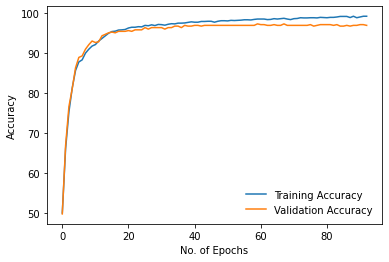

In [115]:
plt.plot(training_history["accuracy"], label="Training Accuracy")
plt.plot(validation_history["accuracy"], label="Validation Accuracy")
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.legend(frameon=False)
plt.show()

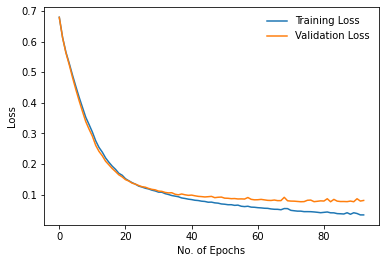

In [116]:
plt.plot(training_history["loss"], label="Training Loss")
plt.plot(validation_history["loss"], label="Validation Loss")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()

### Adding more handlers: Configuring model checkpoint to retain only best models

The current model checkpoint configuration saves checkpoint every n epoch. This may not be the best solution, why not save, for example, the last 2 best models in term of validation loss ?

**Adapt the following code to your use case**

```python

# Store the best model
def default_score_fn(engine):
    score = engine.state.metrics['Accuracy']
    return score


best_model_handler = ModelCheckpoint(dirname=log_path,
                                     filename_prefix="best",
                                     n_saved=3,
                                     global_step_transform=global_step_from_engine(trainer),
                                     score_name="test_acc",
                                     score_function=default_score_fn)
evaluator.add_event_handler(Events.COMPLETED, best_model_handler, {'model': model, })

```

In [118]:
from ignite.handlers import ModelCheckpoint

def default_score_fn(engine):
    score = engine.state.metrics['nll']
    return score

model_name = "basic_cnn"
dataset_name = "toy_aircrafts"

best_model_handler = ignite.handlers.ModelCheckpoint(dirname='./saved_models',
                                                     filename_prefix=dataset_name+'_best',
                                                     n_saved=2,
#                                                     global_step_transform=global_step_from_engine(trainer),
                                                     score_name='validation_loss',
                                                     score_function=default_score_fn,
                                                     require_empty=False)

trainer.add_event_handler(Events.EPOCH_COMPLETED, best_model_handler, {model_name: model})

### Data Augmentation


One technique for training CNNs on images is to put your training data through data augmentation to generate similar-but-different examples to make your network more robust.

You can generate "augmented images" on the fly or use composition to generate data

- We are going to wrap our numpy arrays with `torch.utils.data.Dataset` class

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class

- Here is how we use torch Compose to augment data

https://pytorch.org/docs/stable/torchvision/transforms.html

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms

Note: This step requires a bit of tinkering from numpy arrays to torch datasets, it's fine if you skip it. For the next notebook it may prove a useful way of gaining performance

**Remember : We apply data augmentation only during training**


In [119]:
import torch.functional as F
import torch.utils
import torchvision.transforms

In [120]:
# Example (very simple) data augmentation to get your started, you can add more transforms to this list

train_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.ToTensor(),
    ]
)

In [121]:
trainset_augmented = NpArrayDataset(
    images=train_images, labels=train_labels, image_transforms=train_transform, label_transforms=None
)

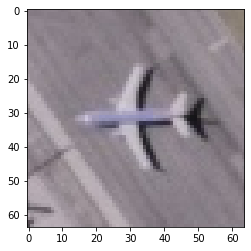

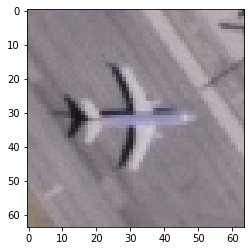

In [122]:
# Get image from dataset. Note: it has been converted as a torch tensor in CHW format in float32 normalized !
img, label = trainset_augmented[0]
img = (img.numpy() * 255.0).astype(np.uint8)
img = np.rollaxis(img, 0, 3)
plt.imshow(img)
plt.show()

# Compare effects of data augmentation
img_orig = trainset_augmented.images[0]
plt.imshow(img_orig)
plt.show()

In [ ]:
# plot our metrics again. Did we change something ?

### [Optional] Trying other models

You have seen a class on different model structure,
https://supaerodatascience.github.io/deep-learning/slides/2_architectures.html#/

Now is the time to try and implement them. For example, try to write a VGG-11 with fewer filters by yourself... or a very small resnet using [this](https://github.com/a-martyn/resnet/blob/master/resnet.py) as inspiration

You can also use models from [torchvision](https://pytorch.org/docs/stable/torchvision/models.html#classification) in your loop, or as inspiration

**Modify the model structure and launch another training... Is it better ?**

### [Optional] Next steps before the next notebooks

- Try to play with network hyperparameters. The dataset is small and allow fast iterations so use it to have an idea on hyperparameter sensitivity.
    number of convolutions, other network structures, learning rates, optimizers,...

- Example: Compare again SGD and ADAM

- Try to use the ROC curve to select a threshold to filter only negative examples without losing any positive examples

When you are done with the warmup, go to the next notebook. But remember that next datasets will be larger and you will not have the time (trainings will take longer ) to experiment on hyperparameters.

**Try more things before going to the next notebook**

## Food for thoughts: Tooling

To conclude this notebook, reflect on the following,

You have launched different experiences and obtained different results,

Did you feel the notebook you used was sufficient ? Which tools would you like to have in order to properly run your experiments ? (Quick google search or ask someone) Do they already exist ?